In [1]:
# import libraries for data and plotting
import glob, os
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot, animation
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import datetime

In [2]:
# importing data
dataDir = '../data/csse_covid_19_data/csse_covid_19_daily_reports/'
allFiles = sorted(glob.glob(dataDir+'/*.csv'))
dfs = []
# saving files in list and creating date column
for path in allFiles:
    df = pd.read_csv(path)
    date = path[len(path) - 14: len(path) - 4]
    df['Date'] = date
    df['Date'] = pd.to_datetime(df['Date'])
    dfs.append(df)

In [3]:
# importing data for daily cases, extract data for KG
dailyCases = pd.read_csv('../data/daily-cases-covid-19.csv')

dfKg = dailyCases[dailyCases['Entity'] == 'Kyrgyzstan']
dfKg.index = range(1,len(dfKg)+1)
dfKg = dfKg.rename(columns={'Daily confirmed cases (cases)': 'Cases'})

In [4]:
# plot some figures
nCases = list(dfKg['Cases'])
totalEachDay = [0]*len(nCases)
totalEachDay[0] = nCases[0]
for i in range(1,len(nCases)):
    totalEachDay[i] = totalEachDay[i-1]+ nCases[i]
days = list(dfKg['Date'])
dfKg['Total'] = totalEachDay
dfKg['nDay'] = range(1, len(dfKg)+1)

In [5]:
# preprocessing data
title = 'Covid in Kg'
x = np.array(dfKg['nDay'])
y = np.array(dfKg['Total'])

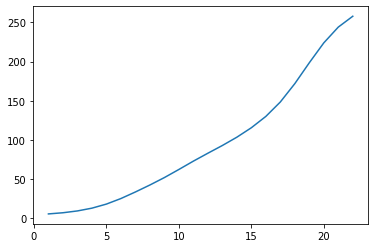

In [6]:
# smoothing the graph
def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))
sigma = fwhm2sigma(4)
smoothed_values = np.zeros(y.shape)

for x_pos in x:
    kernel = np.exp(-(x - x_pos) ** 2/(2*sigma**2))
    kernel = kernel/sum(kernel)
    smoothed_values[x_pos-1] = sum(y * kernel)
pyplot.plot(x, smoothed_values)
y = smoothed_values

In [7]:
#augment the data
def augment(xOld, yOld, nSteps):
    xNew = []
    yNew = []
    for i in range(len(xOld)-1):
        difX = xOld[i+1] - xOld[i]
        stepsX = difX/nSteps
        difY = xOld[i+1] - xOld[i]
        stepsY = difY/nSteps
        for s in range(nSteps):
            xNew = np.append(xNew, xOld[i]+s*stepsX)
            yNew = np.append(yNew, yOld[i]+s*stepsY)
    return xNew, yNew
x, y = augment(x,y,10)

<IPython.core.display.Javascript object>


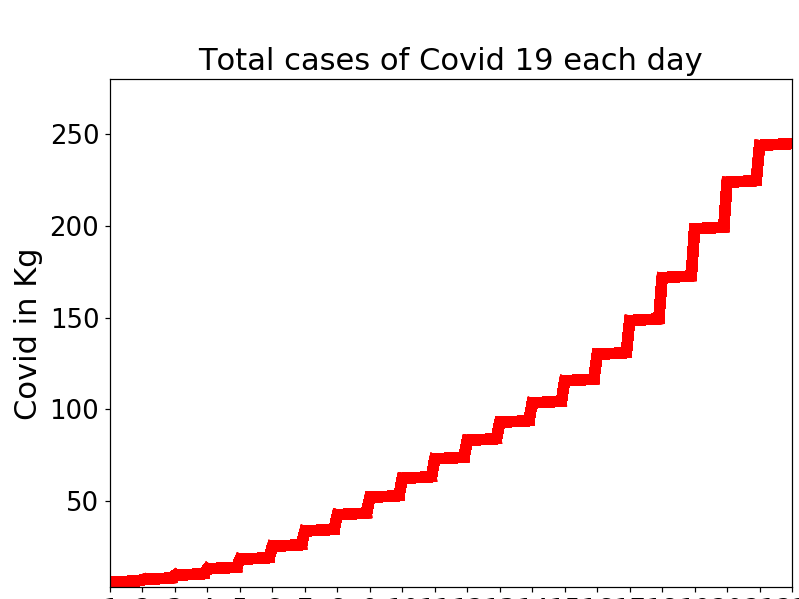

([<matplotlib.axis.XTick at 0x7f4fe7cb97d0>,
 <a list of 22 Text xticklabel objects>)

In [9]:
# preparing plot
%matplotlib notebook
fig = pyplot.figure(figsize=(8,6))
pyplot.xlim(1, len(nCases))
pyplot.ylim(totalEachDay[0], totalEachDay[len(totalEachDay)-1])
pyplot.xlabel('Days', fontsize=20)
pyplot.ylabel('Total cases', fontsize=20)
pyplot.title('Total cases of Covid 19 each day', fontsize=20)
pyplot.xticks(list(dfKg['nDay']))

In [10]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [11]:
kDf = pd.DataFrame(y, x)
kDf.columns = { title }

In [12]:
def animate(i):
    data = kDf.iloc[:int(i+1)]
    p = sns.lineplot(x=data.index, y=data[title], data=data, color="r")
    p.tick_params(labelsize=17)
    pyplot.setp(p.lines, linewidth=7)
anim = animation.FuncAnimation(fig, animate, frames=221, repeat=True)

In [13]:
anim.save('covid.mp4', writer=writer)